In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [2]:
test = pd.read_csv("Test.csv")
train = pd.read_csv("Train.csv")

In [3]:
#make copy of data set
train_original = train.copy()
test_original = test.copy()

In [4]:
train.columns , test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [5]:
train.dtypes , test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [6]:
train.shape , test.shape

((18288, 3), (5112, 2))

In [7]:
train['Datetime']= pd.to_datetime(train['Datetime'] , format='%d-%m-%Y %H:%M')
test['Datetime']= pd.to_datetime(test['Datetime'] , format='%d-%m-%Y %H:%M')
train_original['Datetime']= pd.to_datetime(train_original['Datetime'] , format='%d-%m-%Y %H:%M')
test_original['Datetime']= pd.to_datetime(test_original['Datetime'] , format='%d-%m-%Y %H:%M')

In [8]:
for i in (train ,test,train_original,test_original):
    i['year']= i.Datetime.dt.year
    i['month']= i.Datetime.dt.month
    i['day']= i.Datetime.dt.day
    i['hour']= i.Datetime.dt.hour

In [9]:
#day value 5 and 6 represents weekend
train['day of week']= train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [10]:
# 1 = weekend , 0 = weekdays

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
     return 1
    else:
     return 0
temp2 = train['Datetime'].apply(applyer)
train['weekend']=temp2

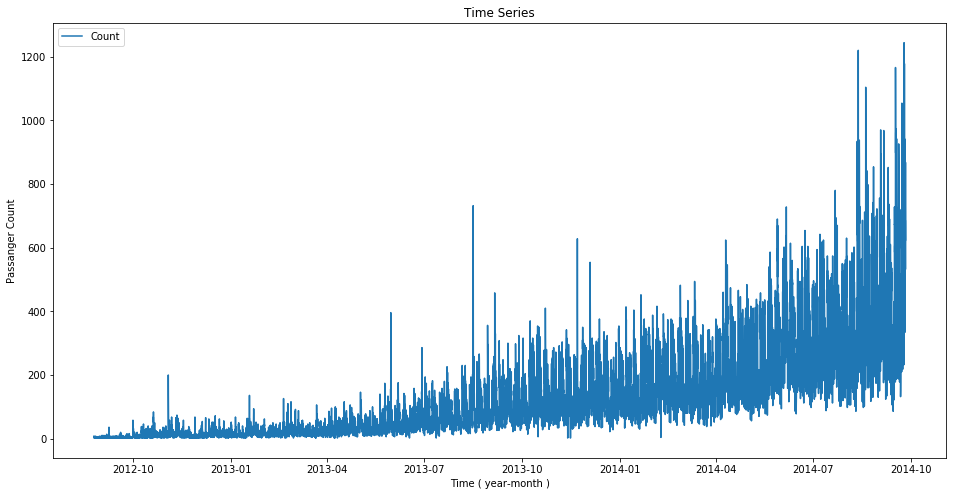

In [11]:
#plotting
train.index = train['Datetime'] #indexing the datetime to get time period on x-axis
df = train.drop('ID',1) # drop id to get only date time on  x-axis
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title('Time Series')
plt.xlabel('Time ( year-month )')
plt.ylabel('Passanger Count')
plt.legend(loc="best")


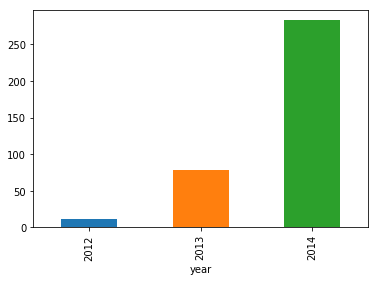

In [12]:
 ###########   HYPOTHESIS
 #    Traffic will increase as the years pass by
 #   Traffic will be high from May to October
 #   Traffic on weekdays will be more
 #   Traffic during the peak hours will be high
    
    #Exploratory Data Analysis
    
# validate 1st hypothesis

train.groupby('year')['Count'].mean().plot.bar()



    

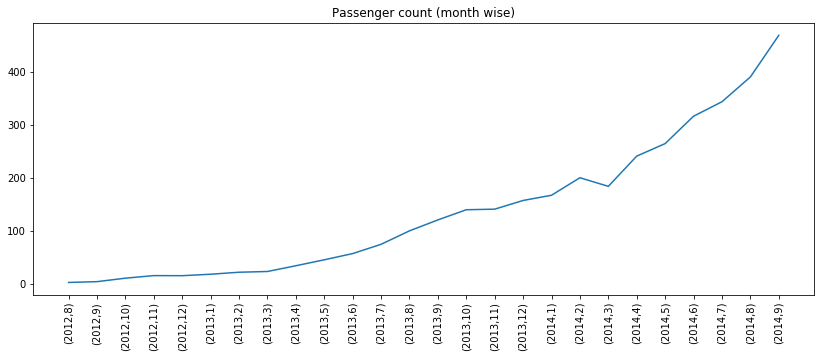

In [13]:
#2nd hypothesis

temp = train.groupby(['year', 'month'])['Count'].mean()
temp = temp.reset_index()
temp['year-mon'] = '('+temp['year'].map(str)+','+temp['month'].map(str)+')'

plt.figure(figsize = (14,5))
plt.plot(temp.index, 'Count', data = temp)
plt.xticks(np.arange(len(temp)), (temp['year-mon']), rotation=90)
plt.title('Passenger count (month wise)');

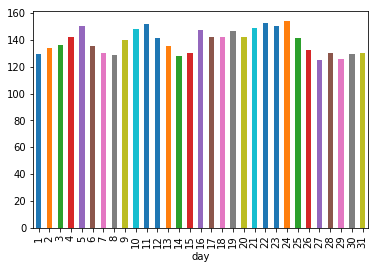

In [14]:
train.groupby('day')['Count'].mean().plot.bar()

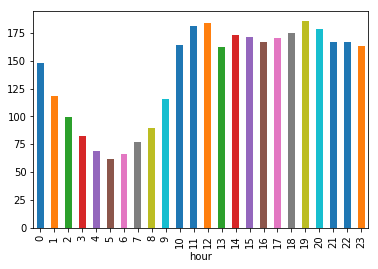

In [15]:
# As we didint get much insight from days now we will look at peek hous
train.groupby('hour')['Count'].mean().plot.bar()

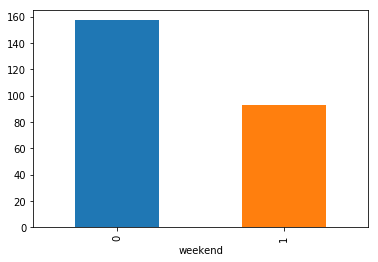

In [16]:
# 3rd hypothesis on weekdays traffic will be more

train.groupby('weekend')['Count'].mean().plot.bar()

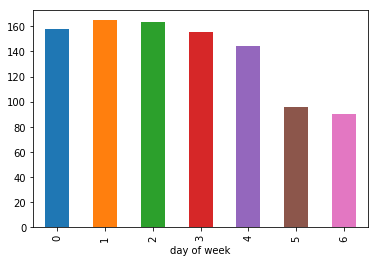

In [17]:
# now try to see day wise traffic
train.groupby('day of week')['Count'].mean().plot.bar()

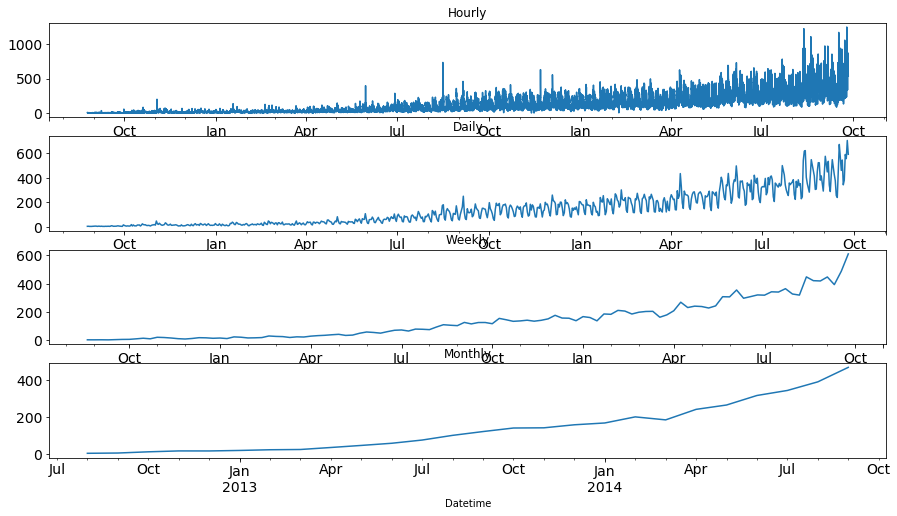

In [18]:
#train = train.drop('ID',1)

# aggregate hourly time series to dayily,monthly and weekly

train.Timestamp = pd.to_datetime(train['Datetime'] , format='%d-%m-%Y %H:%M')
train.index = train.Timestamp

hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize=(15,8), title='Hourly',fontsize=14,ax=axs[0])
daily.Count.plot(figsize=(15,8), title='Daily',fontsize=14,ax=axs[1])
weekly.Count.plot(figsize=(15,8),title='Weekly',fontsize=14,ax=axs[2])
monthly.Count.plot(figsize=(15,8),title='Monthly',fontsize=14,ax=axs[3])

In [19]:
# as it is difficult to convert monthly and weekly series to hourly we will work with daily time series
test.Timestamp = pd.to_datetime(test['Datetime'] , format='%d-%m-%Y %H:%M')
test.index = test.Timestamp

# converting to daily mean
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train['Datetime'] , format='%d-%m-%Y %H-%M')
train.index = train.Timestamp

train = train.resample('D').mean()


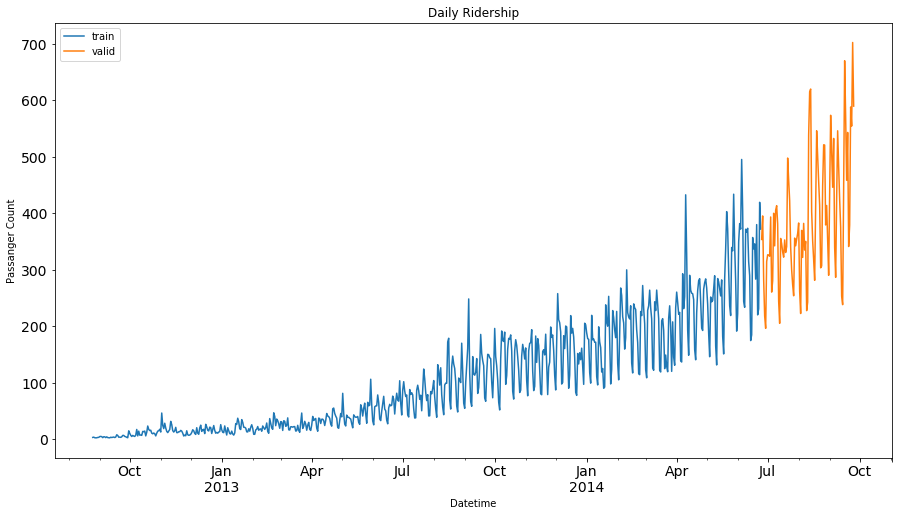

In [20]:
# splitting into training and testing

#we took last 3 months for validation or testing as trend will be high in last months of dataset

Train = train.ix['2012-08-25' : '2014-06-24']
valid = train.ix['2014-06-25' : '2014-09-25']

Train.Count.plot(figsize=(15,8), title='Daily Ridership',fontsize=14,label='train')
valid.Count.plot(figsize=(15,8), title='Daily Ridership',fontsize=14,label='valid')
plt.xlabel('Datetime') 
plt.ylabel("Passanger Count")
plt.legend(loc='best') 
plt.show()



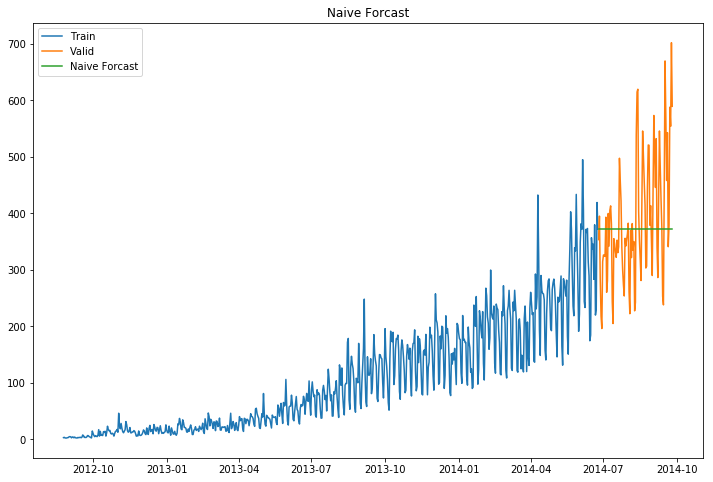

In [21]:
# modeling Approach
# 1. Naive assme that the next expected point will be equal to last observed point

dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['Naive']= dd[len(dd)-1]  # previous value corresponding to a particular value
plt.figure(figsize=(12,8))
plt.plot(Train.index,Train['Count'],label='Train')
plt.plot(valid.index,valid['Count'],label='Valid')
plt.plot(y_hat.index,y_hat['Naive'], label='Naive Forcast')
plt.legend(loc='best')
plt.title("Naive Forcast")
plt.show()



In [22]:
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.Naive)) 
print(rms)

111.79050467496724


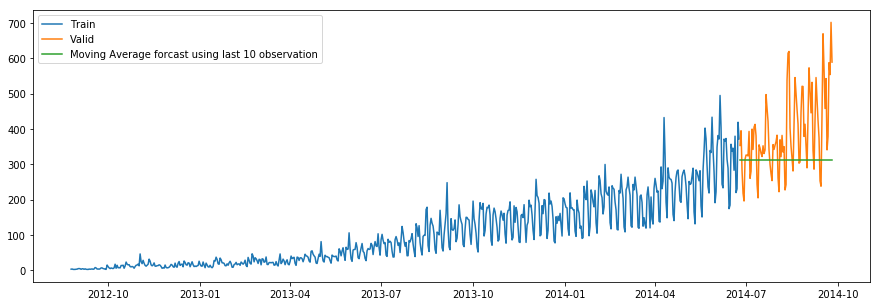

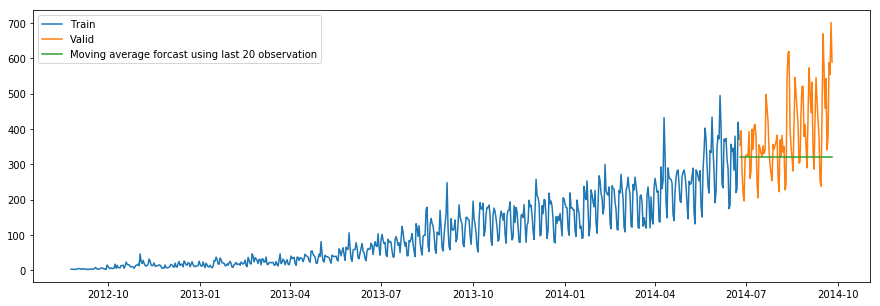

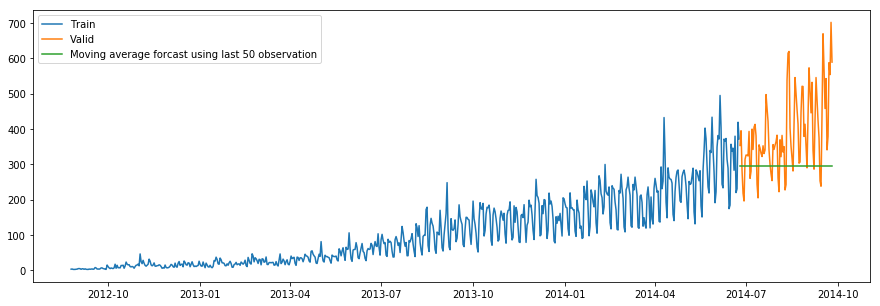

In [23]:
# Moving Average

# considering last 10 observation
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'],label= 'Moving Average forcast using last 10 observation')
plt.legend(loc='best')
plt.show() 
         
# Considering last 20 observation
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(20).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'],label='Moving average forcast using last 20 observation')
plt.legend(loc='best')
plt.show()
         
# Considering last 50 observation
y_hat_avg['moving_avg_forcast'] = Train['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='Valid')
plt.plot(y_hat_avg['moving_avg_forcast'],label='Moving average forcast using last 50 observation')
plt.legend(loc='best')
plt.show()         
         
         


In [24]:
rms = sqrt(mean_squared_error(valid.Count,y_hat_avg.moving_avg_forcast))
print(rms)

144.19175679986802


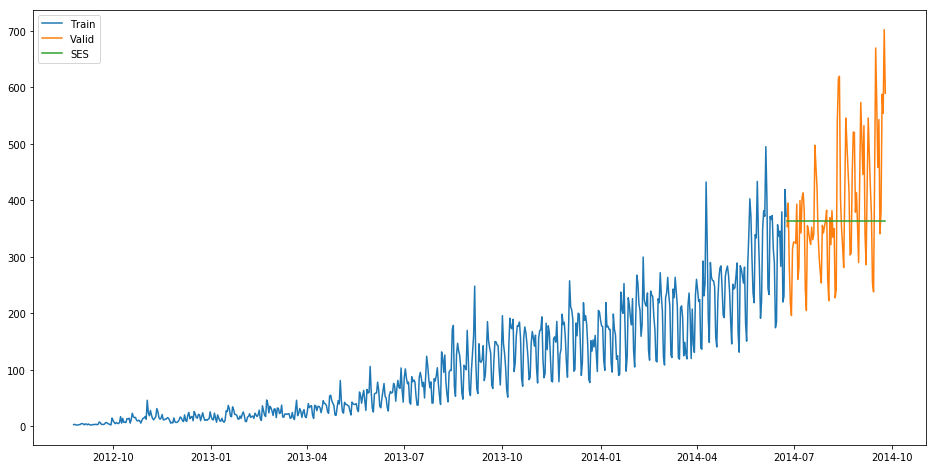

In [25]:
# Simple Exponential Smoothing 

from statsmodels.tsa.api import ExponentialSmoothing 
from statsmodels.tsa.api import SimpleExpSmoothing 
from statsmodels.tsa.api import Holt

y_hat_avg = valid.copy()
f2= SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6 , optimized = False)

y_hat_avg['SES'] = f2.forecast(len(valid))

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [26]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES))
print(rms)

113.43708111884514


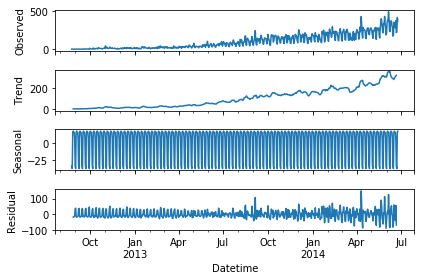

In [27]:
# holt's linear trend model

import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(Train.Count)
plt.show()

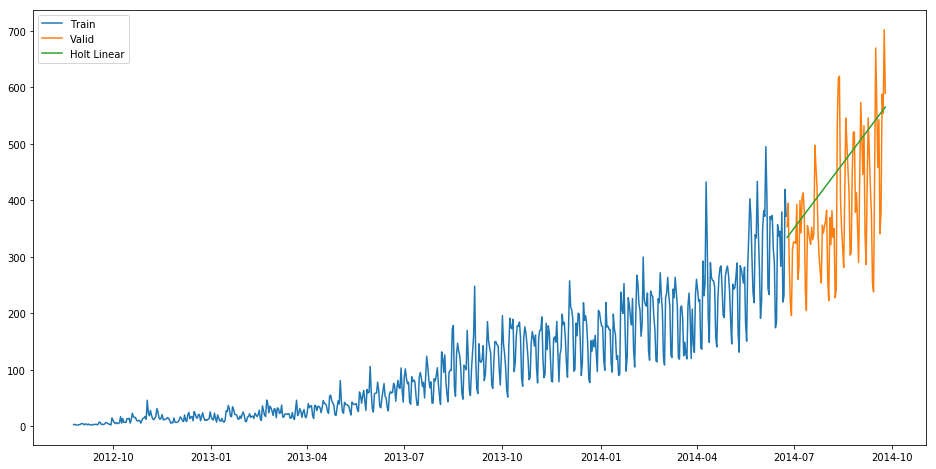

In [28]:
# as trend is increasing we will make our model based on that

y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3 , smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))
            
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['Holt_linear'], label = 'Holt Linear')
plt.legend(loc='best')
plt.show()            


In [29]:
rms = sqrt(mean_squared_error(valid.Count , y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


In [30]:
# holts linear trend model on daily time series

submission = pd.read_csv('submission.csv')

predict = fit1.forecast(len(test))
test['prediction'] = predict

In [31]:
# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

In [32]:
# Grouping the hourly ratio 

temp=train_original.groupby(['hour'])['ratio'].sum() # worked with hour instead of Hour

In [33]:

# Groupby to csv format 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv') 
temp2=pd.read_csv("GROUPby.csv") 
temp2=temp2.drop('Hour',1) 
temp2

,hour,ratio
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802
5,5,0.018621
6,6,0.020023
7,7,0.023221
8,8,0.026741
9,9,0.034555


In [34]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['hour']=merge['hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','hour_x','hour_y'], axis=1)   # again I changes Hour to hour

In [35]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='hour', how='left') 


In [36]:
# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24 
prediction['ID']=prediction['ID_y']

In [37]:
#Let’s drop all other features from the submission file and keep ID and Count only.

submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','hour', 'ratio'],axis=1) 

In [38]:
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

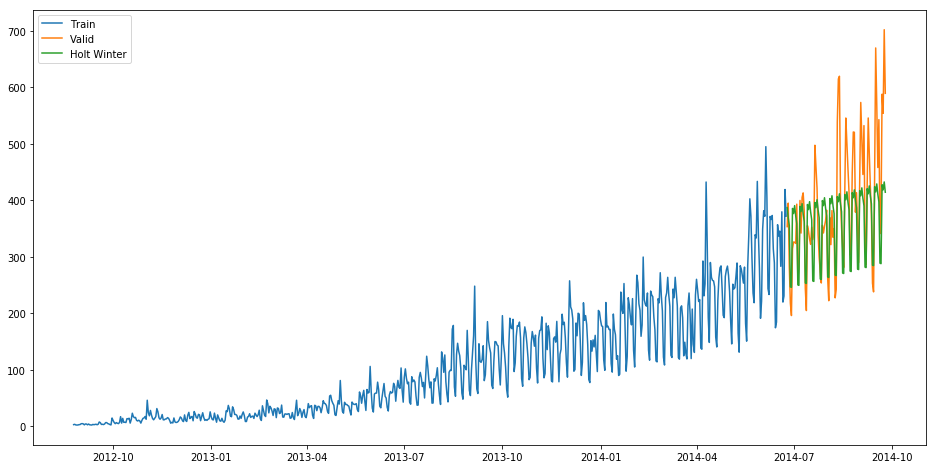

In [39]:
#4) Holt winter’s model on daily time series

#    Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

 #   The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

  #  One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.


# Let’s first fit the model on training dataset and validate it using the validation dataset.

y_hat_avg = valid.copy()
fit1= ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_winter']= fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'],label='Train')
plt.plot(valid['Count'],label='Valid')
plt.plot(y_hat_avg['Holt_winter'],label='Holt Winter')
plt.legend(loc="best")
plt.show()

In [40]:
rmse = sqrt(mean_squared_error(valid.Count,y_hat_avg.Holt_winter))
print(rmse)

82.37527095912128


In [41]:
# We can see that the rmse value has reduced a lot from this method. Let’s forecast the Counts for the entire length of the Test dataset.

predict = fit1.forecast(len(test))

In [42]:
# Merge Test and test_original on day, month and year
merge = pd.merge(test,test_original,on=('day','month','year'),how='left')
merge['hour']=merge['hour_y']
merge=merge.drop(['year','month','Datetime','hour_x','hour_y'],axis=1)

In [43]:
# Predicting by merging merge and temp2 
prediction= pd.merge(merge,temp2,on='hour',how='left')

In [44]:
# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

#Let’s drop all features other than ID and Count
prediction['ID']=prediction['ID_y']
submission = prediction.drop(['day','hour','ratio','prediction','ID_x','ID_y'],axis=1)

In [45]:
# Let’s drop all features other than ID and Count
pd.DataFrame(submission,columns=['ID','Count']).to_csv('Holts_Winter.csv')

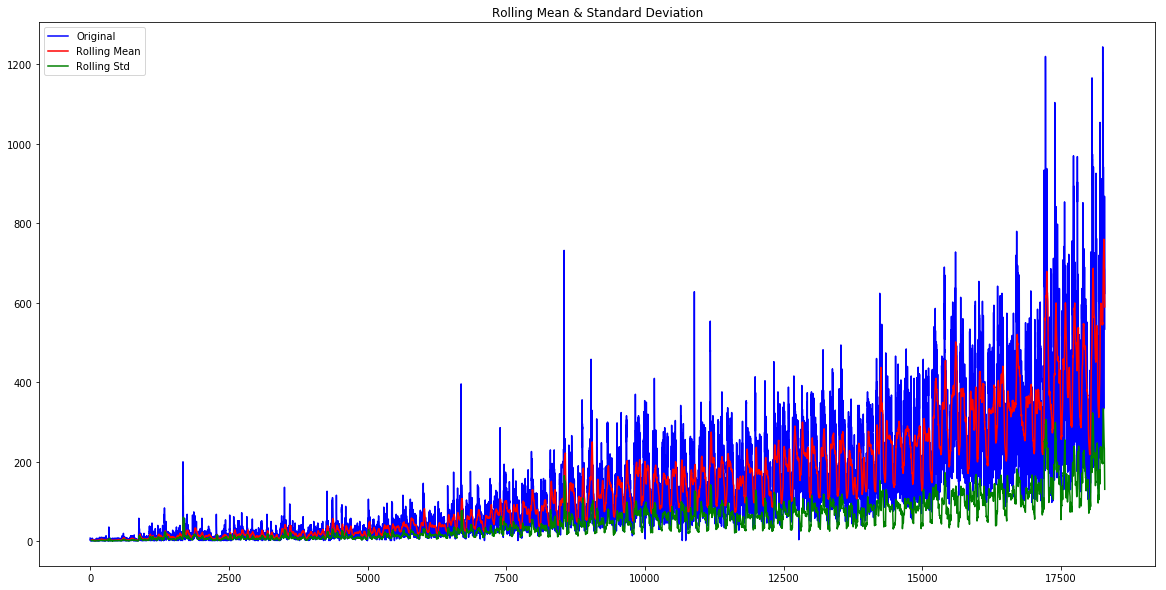

Result of Dickey-fuller test :
Test Statistics               -4.456561
p-value                        0.000235
#Lage used                    45.000000
No of obesrvations used    18242.000000
Critical Value (1%)           -3.430709
Critical Value (5%)           -2.861698
Critical Value (10%)          -2.566854
dtype: float64


In [46]:
# Parameter tuning for ARIMA model
# 1st check for stationarity how ?

# 1 Dickey fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # determing rolling statistics
   
    # rolmean = pd.rolling_mean(timeseries, window=24) ###### not used in present version
    rolmean=pd.Series(timeseries).rolling(window=24).mean()# 24 hours on each day
    rolstd=pd.Series(timeseries).rolling(window=24).std()
    #plot rolling statistics
    orig=plt.plot(timeseries, color='blue',label='Original')
    mean=plt.plot(rolmean, color='red' , label='Rolling Mean')
    std= plt.plot(rolstd, color='green' , label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
     #Perform Dickey-Fuller test:
    print("Result of Dickey-fuller test :")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lage used','No of obesrvations used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
    
test_stationarity(train_original['Count'])
        

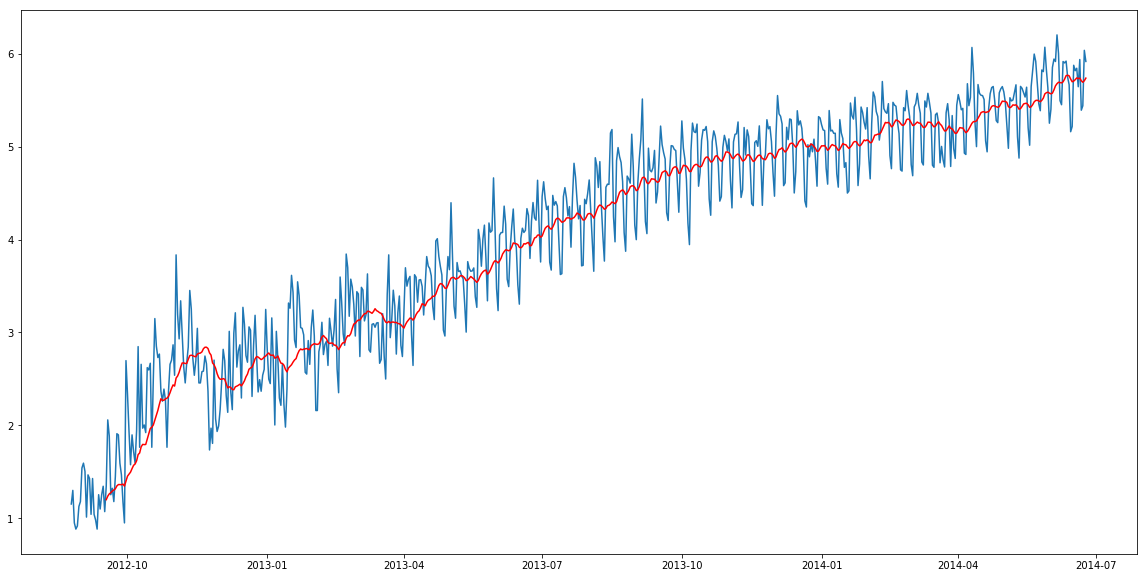

In [47]:
# The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

# Removing Trend

Train_log=np.log(Train['Count'])
Valid_log=np.log(valid['Count'])

moving_avg = pd.Series(Train_log).rolling(window=24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color='red')
plt.show()


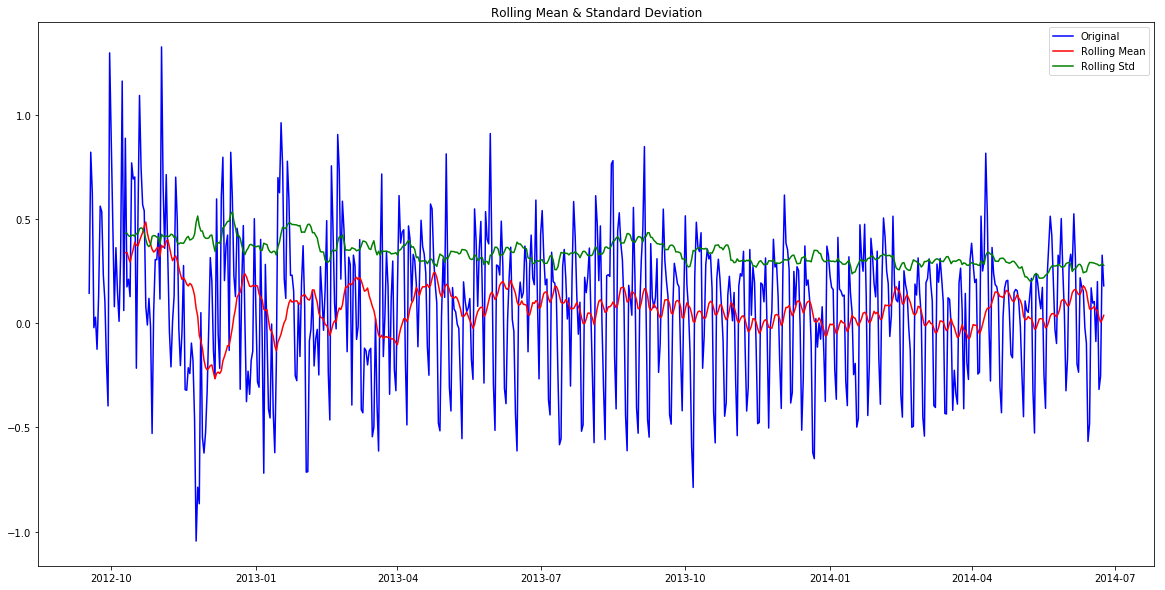

Result of Dickey-fuller test :
Test Statistics           -5.861646e+00
p-value                    3.399422e-07
#Lage used                 2.000000e+01
No of obesrvations used    6.250000e+02
Critical Value (1%)       -3.440856e+00
Critical Value (5%)       -2.866175e+00
Critical Value (10%)      -2.569239e+00
dtype: float64


In [48]:
# So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

train_log_moving_avg_diff = Train_log-moving_avg

# Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

train_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(train_log_moving_avg_diff)

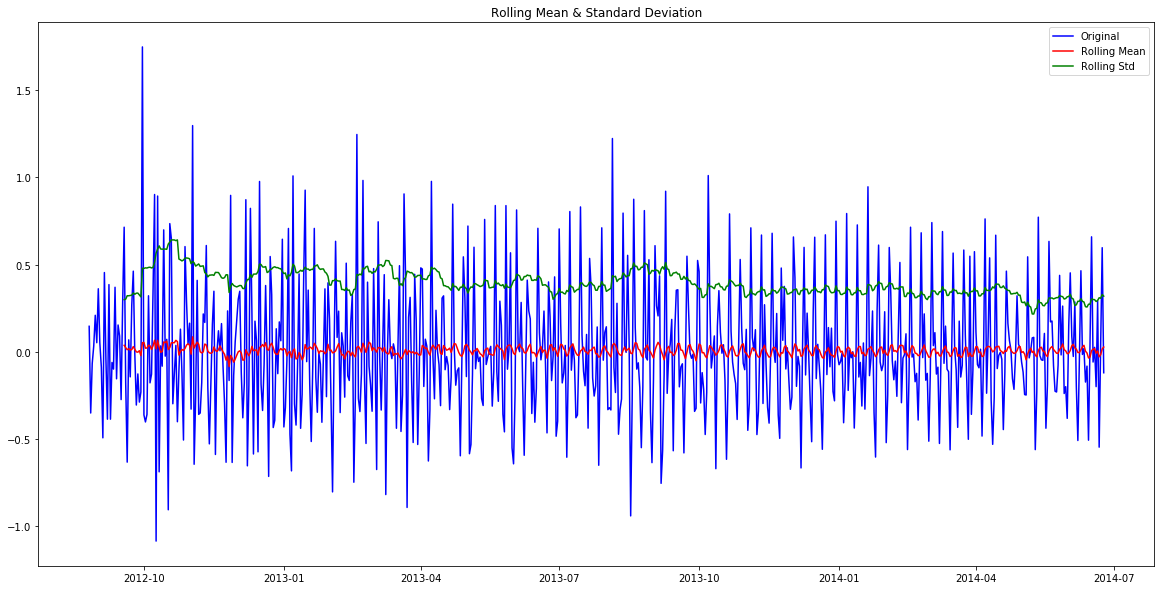

Result of Dickey-fuller test :
Test Statistics           -8.237568e+00
p-value                    5.834049e-13
#Lage used                 1.900000e+01
No of obesrvations used    6.480000e+02
Critical Value (1%)       -3.440482e+00
Critical Value (5%)       -2.866011e+00
Critical Value (10%)      -2.569151e+00
dtype: float64


In [49]:
#We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

#Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

    #Differencing can help to make the series stable and eliminate the trend.
 

train_log_diff = Train_log-Train_log.shift(1)
test_stationarity(train_log_diff.dropna())
    

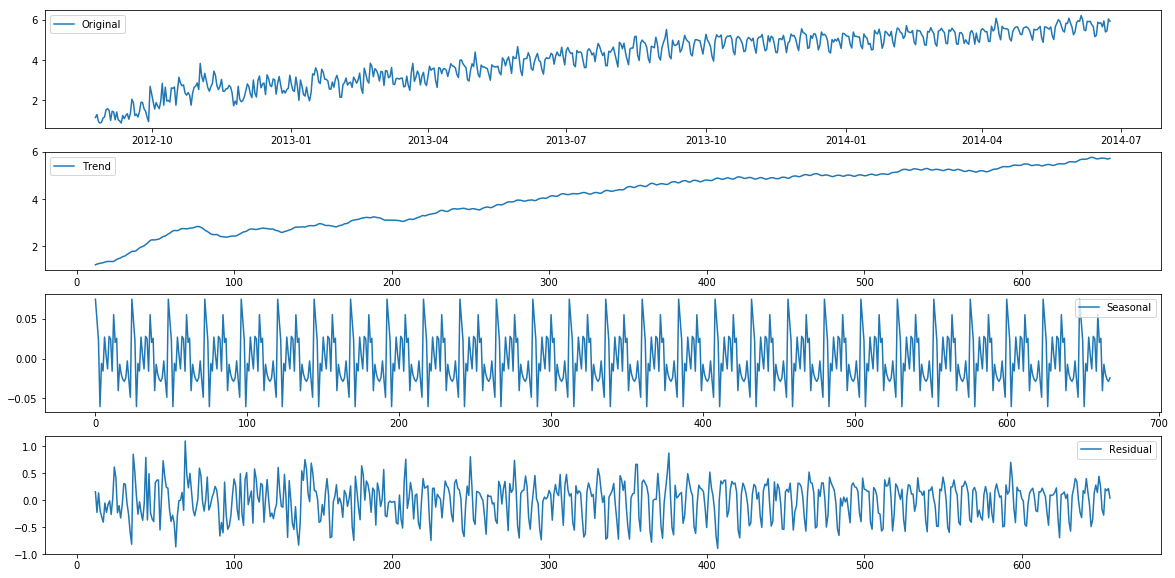

In [50]:
# Removing Seasonality
# We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

from statsmodels.tsa.seasonal import seasonal_decompose

Decomposition = seasonal_decompose (pd.DataFrame(Train_log).Count.values , freq=24)

trend = Decomposition.trend
seasonal = Decomposition.seasonal
residual = Decomposition.resid

plt.subplot(411)
plt.plot(Train_log , label="Original")
plt.legend(loc="best")

plt.subplot(412)
plt.plot(trend , label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal , label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual , label='Residual')
plt.legend(loc='best')
plt.show()


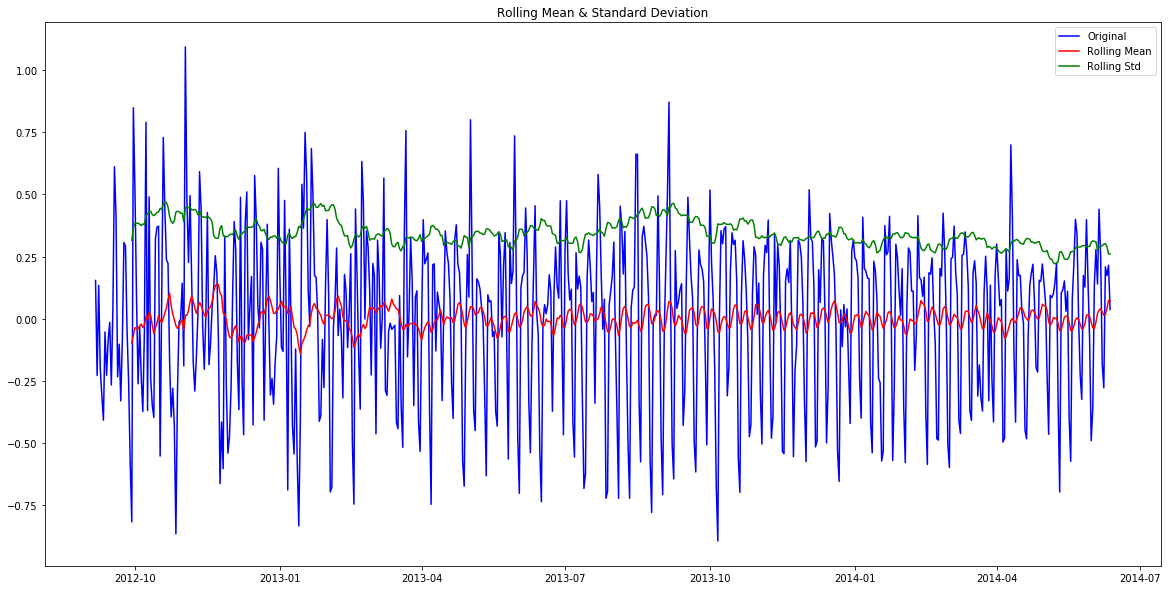

Result of Dickey-fuller test :
Test Statistics           -7.822096e+00
p-value                    6.628321e-12
#Lage used                 2.000000e+01
No of obesrvations used    6.240000e+02
Critical Value (1%)       -3.440873e+00
Critical Value (5%)       -2.866183e+00
Critical Value (10%)      -2.569243e+00
dtype: float64


In [53]:
# check stationarity of residual

train_log_decompose = pd.DataFrame(residual)
train_log_decompose['Date']= Train_log.index
train_log_decompose.set_index('Date',inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

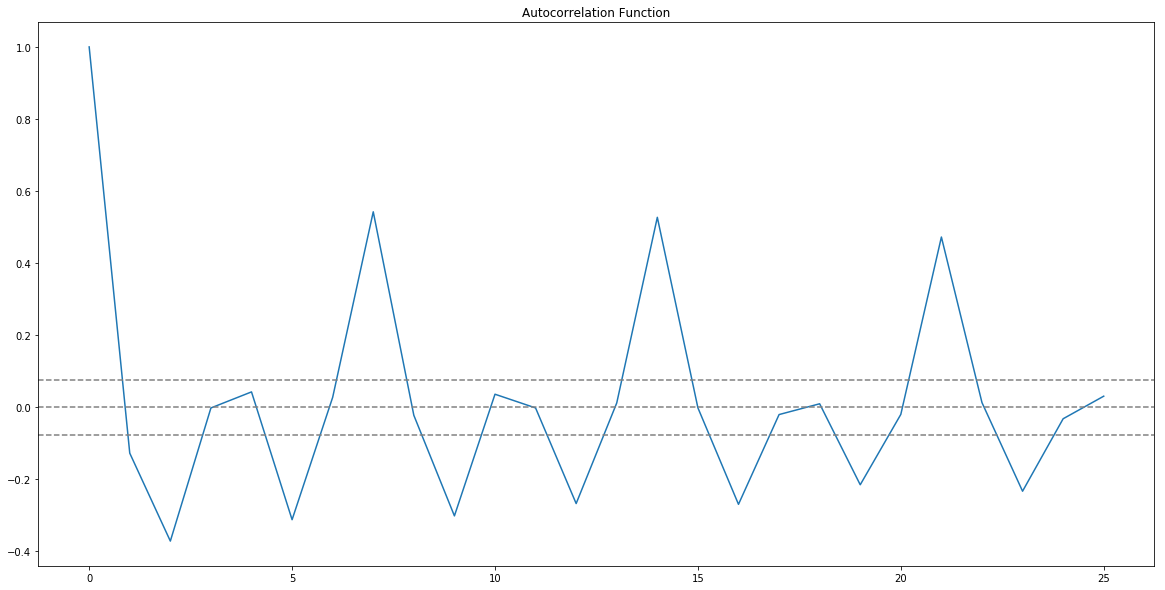

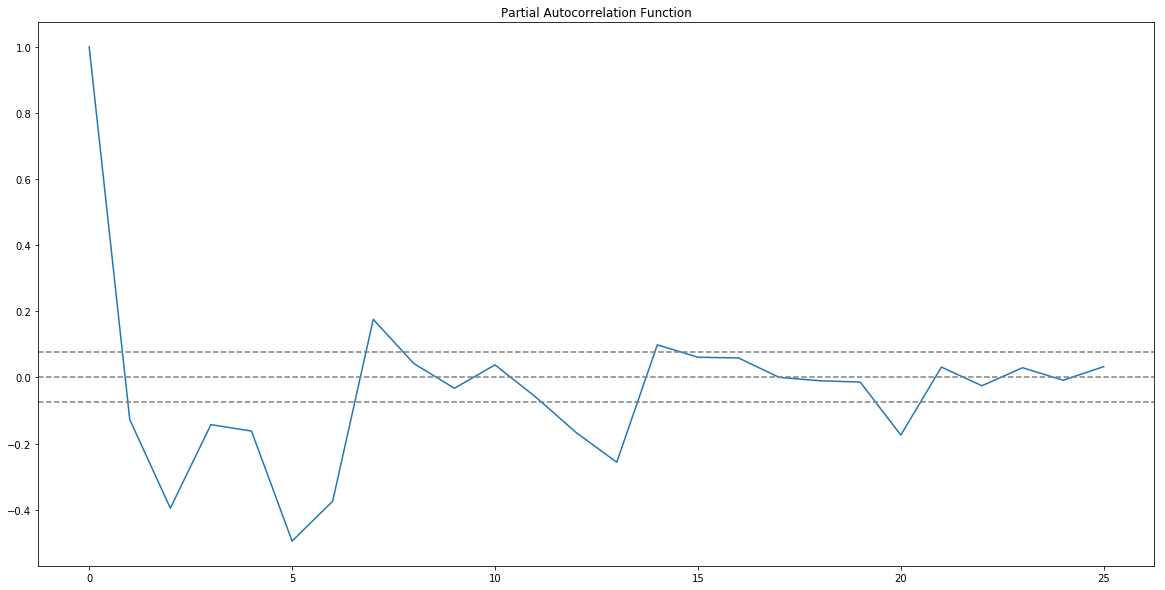

In [61]:
# Above graph states that residual is stationary

## ARIMA Model

# To find the optimized values of these p,d,q we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.


from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(train_log_diff.dropna(),nlags=25)
lag_pacf = pacf(train_log_diff.dropna(),nlags=25,method='ols')


# graph plotting

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())) , linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())) , linestyle='--',color='grey')
plt.title("Autocorrelation Function")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())) , linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())) , linestyle='--',color='grey')
plt.title("Partial Autocorrelation Function")
plt.show()


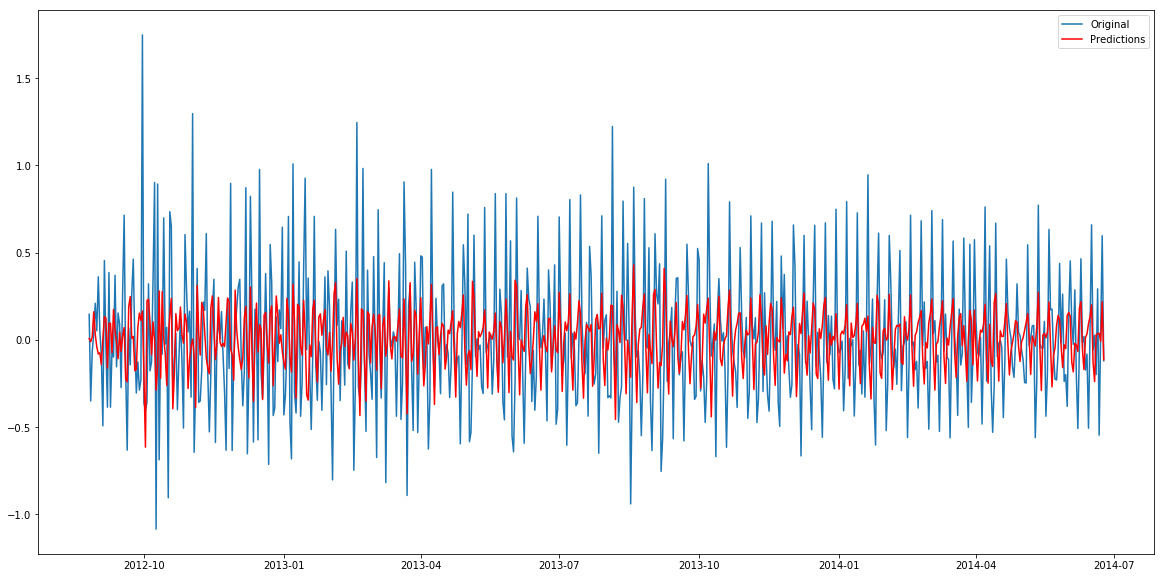

In [65]:
# from above graps we can conclude that p = 1 and q = 1 as at 1 both crossed the upper threshold for the first time.

# AR model

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(Train_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label="Original")
plt.plot(results_AR.fittedvalues,color='red',label='Predictions')
plt.legend(loc="best")
plt.show()


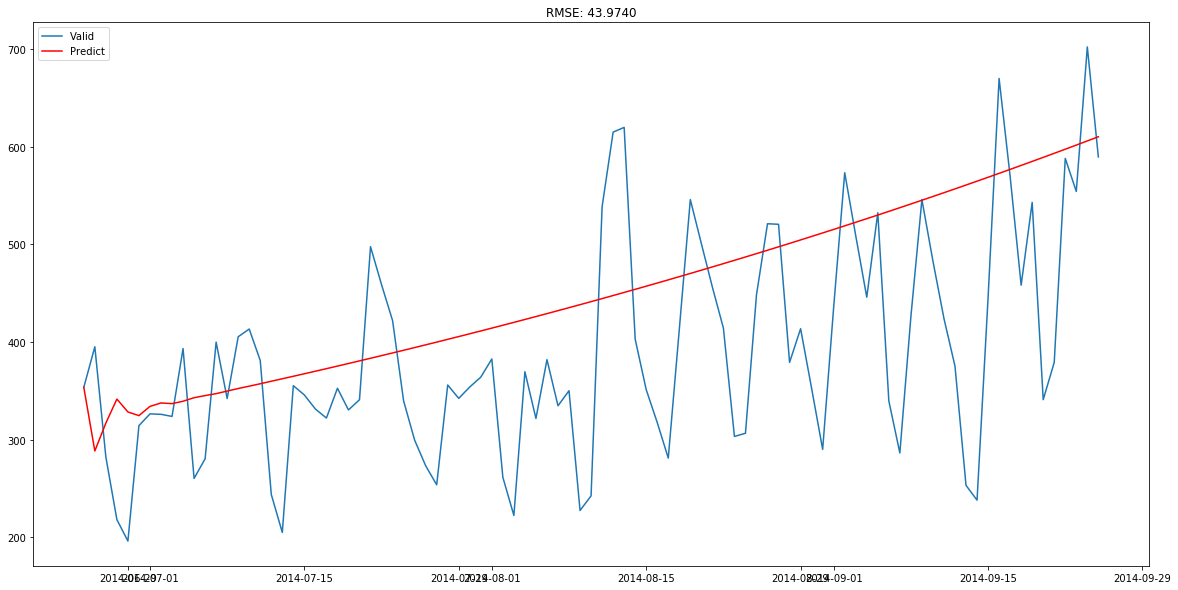

In [67]:
# change the scale of the model to original scale to plot the validation curve

AR_predict = results_AR.predict(start="2014-06-25",end="2014-09-25")
AR_predict = AR_predict.cumsum().shift().fillna(0)

AR_predict1 = pd.Series(np.ones(valid.shape[0])*np.log(valid['Count'])[0],index=valid.index)
AR_predict1 = AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

plt.plot(valid['Count'],label="Valid")
plt.plot(AR_predict,color='red',label='Predict')
plt.legend(loc="best")
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()

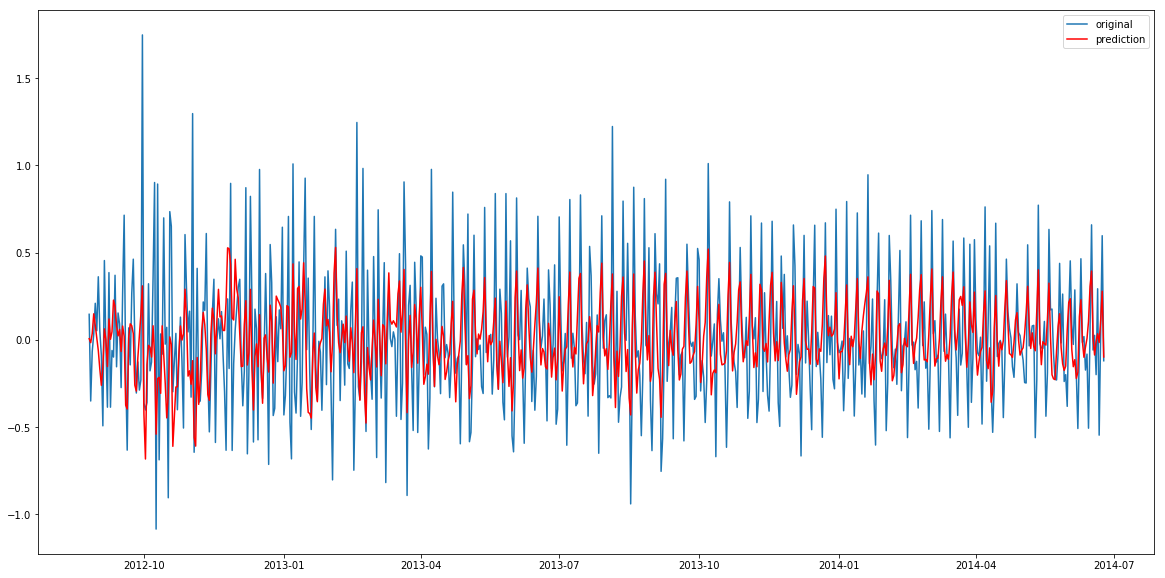

In [69]:
### MA Model

model = ARIMA(Train_log,order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

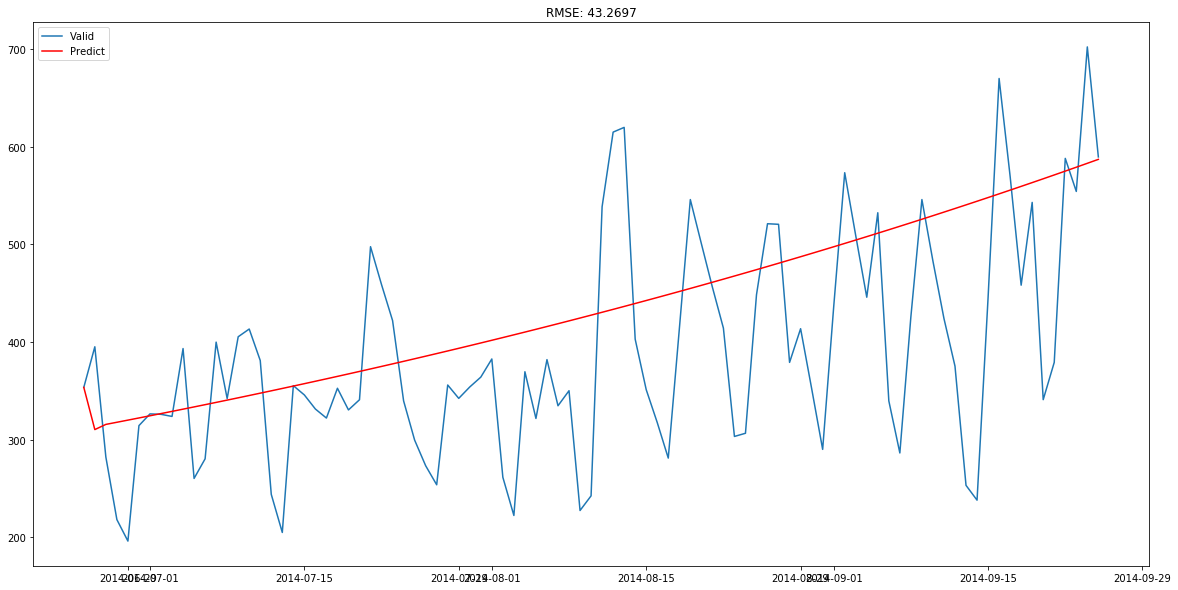

In [71]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)

plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()

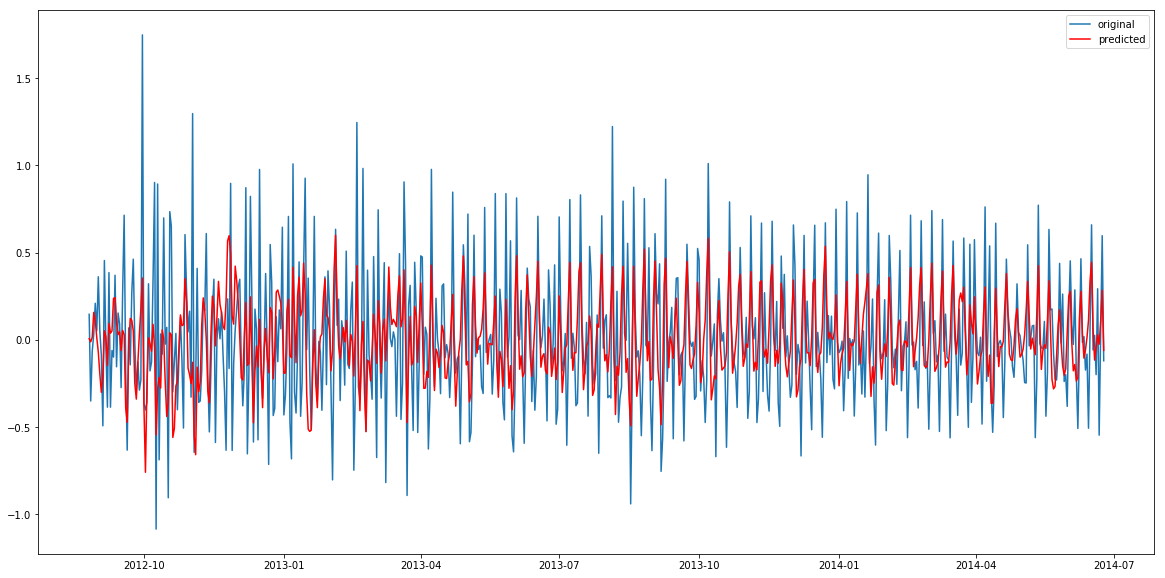

In [72]:
## COMBINDE MODEL - ARIMA

model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

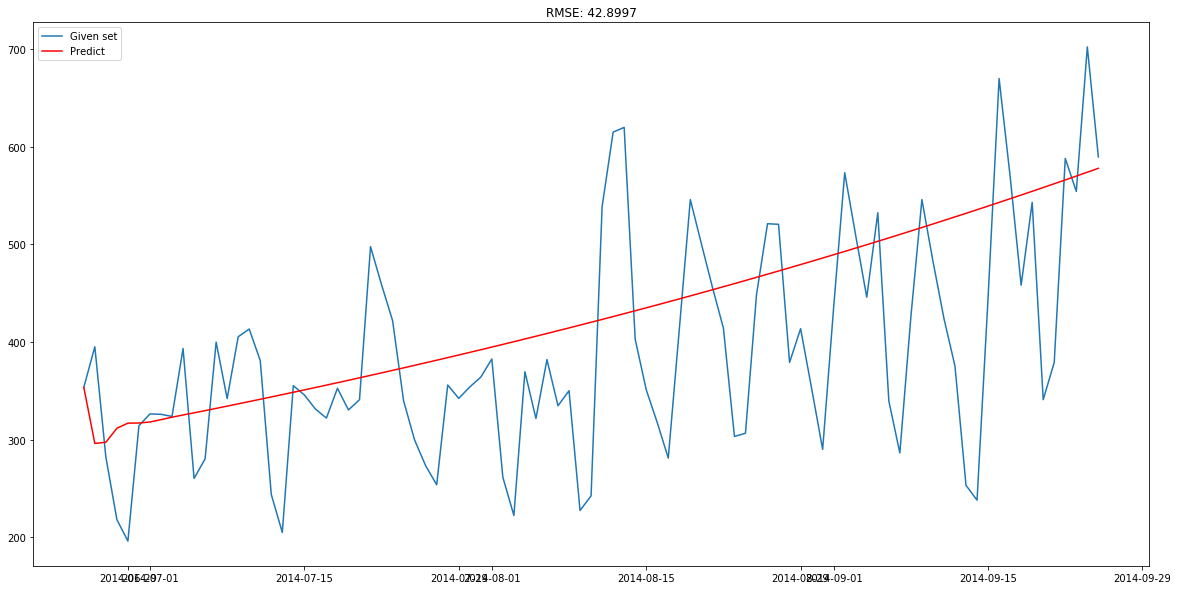

In [73]:
## Let’s define a function which can be used to change the scale of the model to the original scale.

def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()


def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

## Let’s predict the values for validation set.

ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

check_prediction_diff(ARIMA_predict_diff, valid)

/home/rachana/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


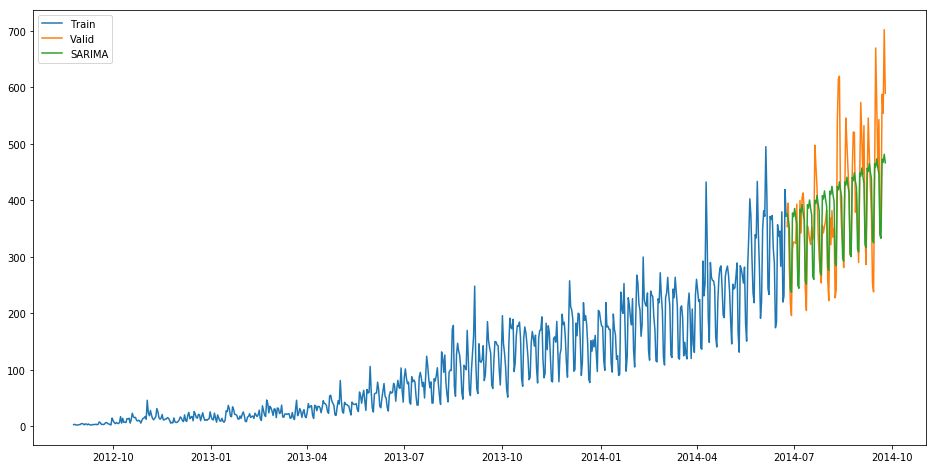

In [74]:
# SARIMAX model on daily time series
### SARIMAX model takes into account the seasonality of the time series.

import statsmodels.api as sm

y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [75]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 
print(rms)

69.76036366955455


In [81]:
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)


# Note that these are the daily predictions and we need hourly predictions.
# So, we will distribute this daily prediction into hourly counts.
# To do so, we will take the ratio of hourly distribution of passenger count from train data and then we will distribute the predictions in the same ratio.

test['prediction']=predict

# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['hour']=merge['hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','hour_x','hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='hour', how='left') 

# Converting the ratio to the original scale prediction['Count']=prediction['prediction']*prediction['ratio']*24

#Let’s drop all variables other than ID and Count

prediction['ID']=prediction['ID_y']
submission=prediction.drop(['day','hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')



/home/rachana/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)
